# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [64]:
# Settings the warnings to be ignored
import warnings  
warnings.filterwarnings('ignore') 

# Importing the data and converting income column to binary classes
import pandas as pd

In [65]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [66]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Define X and Y dataframes
X = fires_dt.iloc[:,:-1]
Y = fires_dt['area']

# Using sklearn's train_test_split to split data
X_train, X_test, y_train, y_test = train_test_split(X, Y , random_state=42, test_size=0.30)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [67]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PowerTransformer
from sklearn import set_config

set_config(display='diagram')

# Define individual transformers
Rscaler = RobustScaler()
OneHEncoder = OneHotEncoder(handle_unknown='infrequent_if_exist', drop='if_binary')

#Define column groups
num_columns = X.select_dtypes(include='number').columns
cat_columns = X.select_dtypes(include='object').columns

# Create pipelines for each type of column
num_pipeline1 = Pipeline([
    ('RobustScaler', Rscaler)
])

cat_pipeline1 = Pipeline([
    ('OneHotEncoder', OneHEncoder)
])

# Apply the ColumnTransformer to column groups
Preproc1 = ColumnTransformer([
    ('num_transforms', num_pipeline1, num_columns),
    ('cat_transforms', cat_pipeline1, cat_columns)
])

# Inspect transformer results
Preproc1

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('RobustScaler',
                                                  RobustScaler())]),
                                 Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                ('cat_transforms',
                                 Pipeline(steps=[('OneHotEncoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'))]),
                                 Index(['month', 'day'], dtype='object'))])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [68]:
# Create pipelines for each type of column
num_pipeline2 = Pipeline([
    ('RobustScaler', Rscaler),
    ('transform', PowerTransformer(method='yeo-johnson'))
])

cat_pipeline2 = Pipeline([
    ('OneHotEncoder', OneHEncoder)
])

# Apply the ColumnTransformer to column groups
Preproc2 = ColumnTransformer([
    ('num_transforms', num_pipeline2, num_columns),
    ('cat_transforms', cat_pipeline2, cat_columns)
])

# Inspect transformer results
Preproc2

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('RobustScaler',
                                                  RobustScaler()),
                                                 ('transform',
                                                  PowerTransformer())]),
                                 Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                ('cat_transforms',
                                 Pipeline(steps=[('OneHotEncoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'))]),
                                 Index(['month', 'day'], dtype='object'))])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [69]:
# Pipeline A = preproc1 + baseline
from sklearn import linear_model

# Create mode pipeline with preprocessing and regressor
model_pipelineA = Pipeline([
    ('preprocessing', Preproc1),
    ('regressor', linear_model.Ridge())
])

# Inspect model pipeline results 
model_pipelineA

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('RobustScaler',
                                                                   RobustScaler())]),
                                                  Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='infrequent_if_exist'))]),
                                                  Index(['month', 'day'], dtype='object'))])),
                ('regressor', Ridge())])

In [70]:
# Pipeline B = preproc2 + baseline

# Create mode pipeline with preprocessing and regressor
model_pipelineB = Pipeline([
    ('preprocessing', Preproc2),
    ('regressor', linear_model.Lasso())
])

# Inspect model pipeline results 
model_pipelineB


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('RobustScaler',
                                                                   RobustScaler()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='infrequent_if_exist'))]),
                                                  Index(['month', 'day'], dtype='object'))])),
                ('regressor', Lasso())])

In [71]:
# Pipeline C = preproc1 + advanced model
from sklearn.ensemble import BaggingRegressor

# Create mode pipeline with preprocessing and regressor
model_pipelineC = Pipeline([
    ('preprocessing', Preproc1),
    ('regressor', BaggingRegressor())
])

# Inspect model pipeline results 
model_pipelineC

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('RobustScaler',
                                                                   RobustScaler())]),
                                                  Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='infrequent_if_exist'))]),
                                                  Index(['month', 'day'], dtype='object'))])),
                ('regressor', BaggingRegressor())])

In [72]:
# Pipeline D = preproc2 + advanced model

# Create mode pipeline with preprocessing and regressor
model_pipelineD = Pipeline([
    ('preprocessing', Preproc2),
    ('regressor', BaggingRegressor())
])

# Inspect model pipeline results 
model_pipelineD
    

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('RobustScaler',
                                                                   RobustScaler()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='infrequent_if_exist'))]),
                                                  Index(['month', 'day'], dtype='object'))])),
                ('regressor', BaggingRegressor())])

In [73]:
#Check available parameters for each pipeline
#model_pipelineA.get_params()
model_pipelineB.get_params()
#model_pipelineC.get_params()
#model_pipelineD.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('num_transforms',
                                    Pipeline(steps=[('RobustScaler',
                                                     RobustScaler()),
                                                    ('transform',
                                                     PowerTransformer())]),
                                    Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
          'rain'],
         dtype='object')),
                                   ('cat_transforms',
                                    Pipeline(steps=[('OneHotEncoder',
                                                     OneHotEncoder(drop='if_binary',
                                                                   handle_unknown='infrequent_if_exist'))]),
                                    Index(['month', 'day'], dtype='object'))])),
  ('regressor', Lasso())],
 'verbose': False,
 'preprocessi

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [74]:
#Tuning PipelineA

param_gridA = {
    'regressor__alpha': [0.5, 1],
    'regressor__solver': ['lsqr', 'cholesky'],
    }

scoringA = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']

grid_cvA = GridSearchCV(
    estimator=model_pipelineA, 
    param_grid=param_gridA, 
    scoring = scoringA, 
    cv = 5,
    refit = "neg_root_mean_squared_error")

grid_cvA.fit(X_train, y_train)

resA = grid_cvA.cv_results_
resA = pd.DataFrame(resA)
resA.columns

resA[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_regressor__alpha', 'param_regressor__solver', 'params',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error',
       'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
       'rank_test_neg_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error']].sort_values('rank_test_neg_root_mean_squared_error')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_regressor__solver,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
3,0.005411,0.000114,0.002563,0.000025,1.0,cholesky,"{'regressor__alpha': 1, 'regressor__solver': '...",-19.590895,4.270732,2,-2474.070917,2920.745841,1,-43.165893,24.713894,1
2,0.006102,0.000071,0.002613,0.000071,1.0,lsqr,"{'regressor__alpha': 1, 'regressor__solver': '...",-19.590642,4.274354,1,-2475.403423,2920.078344,2,-43.189420,24.699745,2
1,0.005587,0.000376,0.002606,0.000072,0.5,cholesky,"{'regressor__alpha': 0.5, 'regressor__solver':...",-19.778081,4.243947,3,-2490.836680,2912.275524,3,-43.456453,24.543296,3
0,0.007129,0.000975,0.002912,0.000287,0.5,lsqr,"{'regressor__alpha': 0.5, 'regressor__solver':...",-19.791284,4.240492,4,-2494.670417,2910.127588,4,-43.522703,24.503974,4


In [75]:
#Tuning PipelineB

param_gridB = {
    'regressor__alpha': [0.5, 1],
    'regressor__selection': ['cyclic', 'random'],
    }

scoringB = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']

grid_cvB = GridSearchCV(
    estimator=model_pipelineB, 
    param_grid=param_gridB, 
    scoring = scoringB, 
    cv = 5,
    refit = "neg_root_mean_squared_error")

grid_cvB.fit(X_train, y_train)

resB = grid_cvB.cv_results_
resB = pd.DataFrame(resB)
resB.columns

resB[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_regressor__alpha', 'param_regressor__selection', 'params',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error',
       'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
       'rank_test_neg_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error']].sort_values('rank_test_neg_root_mean_squared_error')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_regressor__selection,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
2,0.015409,0.000703,0.003273,0.000149,1.0,cyclic,"{'regressor__alpha': 1, 'regressor__selection'...",-17.587331,4.050067,1,-2350.911734,2929.999527,1,-41.255506,25.473417,1
3,0.015185,0.000610,0.003184,0.000064,1.0,random,"{'regressor__alpha': 1, 'regressor__selection'...",-17.587468,4.049894,2,-2350.924397,2930.001617,2,-41.255686,25.473373,2
1,0.016072,0.000500,0.003486,0.000214,0.5,random,"{'regressor__alpha': 0.5, 'regressor__selectio...",-18.149382,4.203545,3,-2376.702166,2928.531572,3,-41.685606,25.278696,3
0,0.016303,0.001398,0.003437,0.000162,0.5,cyclic,"{'regressor__alpha': 0.5, 'regressor__selectio...",-18.150065,4.203443,4,-2376.735432,2928.494262,4,-41.686403,25.278039,4


In [76]:
#Tuning PipelineC

param_gridC = {
    'regressor__bootstrap': [True, False],
    'regressor__bootstrap_features': [True, False],
    }

scoringC = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']

grid_cvC = GridSearchCV(
    estimator=model_pipelineC, 
    param_grid=param_gridC, 
    scoring = scoringC, 
    cv = 5,
    refit = "neg_root_mean_squared_error")

grid_cvC.fit(X_train, y_train)

resC = grid_cvC.cv_results_
resC = pd.DataFrame(resC)
resC.columns

resC[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_regressor__bootstrap', 'param_regressor__bootstrap_features',
       'params',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error',
       'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
       'rank_test_neg_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error']]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__bootstrap,param_regressor__bootstrap_features,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,0.036454,0.003930,0.005854,0.002018,True,True,"{'regressor__bootstrap': True, 'regressor__boo...",-23.680623,6.105143,3,-3494.536617,2765.856655,3,-54.741714,22.313255,3
1,0.030659,0.000446,0.004018,0.000202,True,False,"{'regressor__bootstrap': True, 'regressor__boo...",-21.199132,4.817207,1,-3109.042086,2881.606576,1,-50.831229,22.917858,1
2,0.037702,0.001499,0.003778,0.000149,False,True,"{'regressor__bootstrap': False, 'regressor__bo...",-22.905358,6.348181,2,-3484.093691,2899.916429,2,-54.231537,23.303093,2
3,0.039884,0.001211,0.004088,0.000361,False,False,"{'regressor__bootstrap': False, 'regressor__bo...",-25.516477,9.097684,4,-5864.232261,4415.730812,4,-70.243471,30.497328,4


In [77]:
#Tuning PipelineD

param_gridD = {
    'regressor__bootstrap': [True, False],
    'regressor__bootstrap_features': [True, False],
    }

scoringD = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']

grid_cvD = GridSearchCV(
    estimator=model_pipelineD, 
    param_grid=param_gridD, 
    scoring = scoringD, 
    cv = 5,
    refit = "neg_root_mean_squared_error")

grid_cvD.fit(X_train, y_train)

resD = grid_cvD.cv_results_
resD = pd.DataFrame(resD)
resD.columns

resD[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_regressor__bootstrap', 'param_regressor__bootstrap_features',
       'params',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error',
       'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
       'rank_test_neg_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error']]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__bootstrap,param_regressor__bootstrap_features,params,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,0.046848,0.000945,0.004742,0.000350,True,True,"{'regressor__bootstrap': True, 'regressor__boo...",-22.689384,5.387602,2,-3089.462977,2816.873480,1,-50.658705,22.872660,1
1,0.044417,0.001686,0.005876,0.001237,True,False,"{'regressor__bootstrap': True, 'regressor__boo...",-22.763892,5.040135,3,-3631.580140,2929.609264,3,-55.519367,23.434591,3
2,0.049559,0.001460,0.004897,0.000565,False,True,"{'regressor__bootstrap': False, 'regressor__bo...",-21.892123,6.411940,1,-3202.377858,3032.605061,2,-51.198264,24.106340,2
3,0.052008,0.001529,0.005074,0.000640,False,False,"{'regressor__bootstrap': False, 'regressor__bo...",-24.926094,8.502073,4,-5949.933868,4267.630110,4,-70.999127,30.150587,4


# Evaluate

+ Which model has the best performance?

In [97]:
print(f'mean_validation_neg_RSME_PipelineA:',resA.mean_test_neg_root_mean_squared_error.max())
print(f'mean_validation_neg_RSME_PipelineB:',resB.mean_test_neg_root_mean_squared_error.max())
print(f'mean_validation_neg_RSME_PipelineC:',resC.mean_test_neg_root_mean_squared_error.max())
print(f'mean_validation_neg_RSME_PipelineD:',resD.mean_test_neg_root_mean_squared_error.max(),'\n\n')

print(f'mean_validation_neg_MAE_PipelineA:',resA.mean_test_neg_mean_absolute_error.max())
print(f'mean_validation_neg_MAE_PipelineB:',resB.mean_test_neg_mean_absolute_error.max())
print(f'mean_validation_neg_MAE_PipelineC:',resC.mean_test_neg_mean_absolute_error.max())
print(f'mean_validation_neg_MAE_PipelineD:',resD.mean_test_neg_mean_absolute_error.max())


mean_validation_neg_RSME_PipelineA: -43.16589321317605
mean_validation_neg_RSME_PipelineB: -41.255505892760176
mean_validation_neg_RSME_PipelineC: -50.83122911773562
mean_validation_neg_RSME_PipelineD: -50.658704909649074 


mean_validation_neg_MAE_PipelineA: -19.59064207919873
mean_validation_neg_MAE_PipelineB: -17.587330853479937
mean_validation_neg_MAE_PipelineC: -21.199132486047688
mean_validation_neg_MAE_PipelineD: -21.892122560882797


>Answer: Based on the RSME and MAE scores PipelineB model has the best performance as they are closer to 0.

# Export

+ Save the best performing model to a pickle file.

In [100]:
import pickle

# Save the model to a file
with open('../../05_src/data/artifacts/model.pkl', 'wb') as file:
    pickle.dump(grid_cvB.best_estimator_, file)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [103]:
import shap
with open('../../05_src/data/artifacts/model.pkl', 'rb') as file:
    pipe = pickle.load(file)

pipe


data_transform = pipe.named_steps['preprocessing'].transform(X_test)

explainer = shap.explainers.Linear(
    pipe.named_steps['regressor'], 
    data_transform,
    feature_names = pipe.named_steps['preprocessing'].get_feature_names_out())

shap_values = explainer(data_transform)

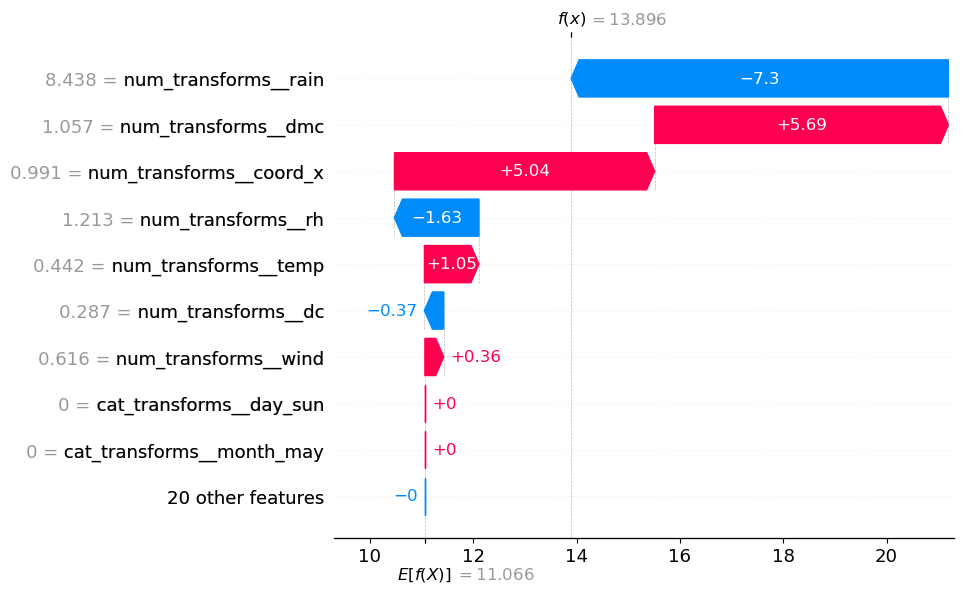

In [105]:
shap.plots.waterfall(shap_values[1])

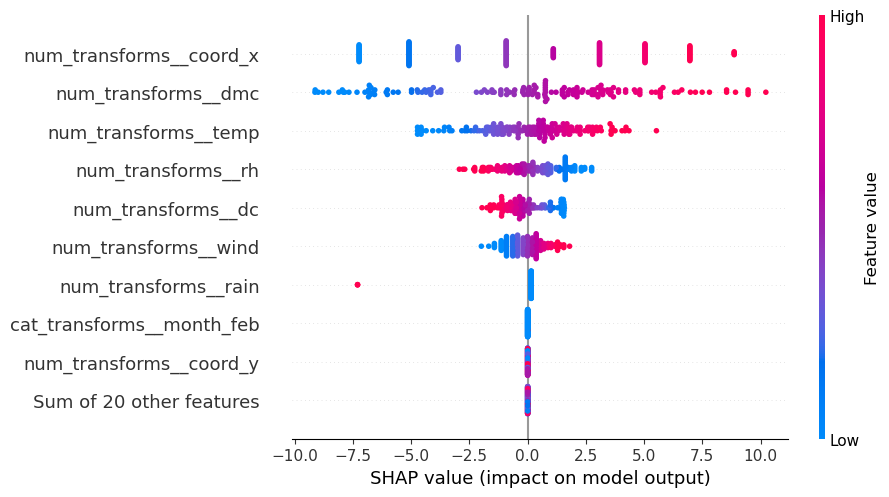

In [106]:
shap.plots.beeswarm(shap_values)

### Reminder of variable descriptions

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 

+ Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

>Answer: According to the SHAP plots coord_x, rain, DMC, temp, rh, dc and wind are the features that most influence the results of the model. For the observation below (in order of importance according to waterfall plot):

- rain = 0 - is the lowest in the range, no influence in prediction. (-7.3)
- DMC = 130.1 - is in the middle of the range, SHAP values indicate this positively influences the prediction. (5.69)
- Coord_x = 6 - is relatively high given the range (1 to 9), SHAP values indicate this positively influences the prediction. (5.04)
- rh = 37 - is in the lower part of the range, SHAP values indicate this negatively influences the prediction. (-1.63)
- temp = 20.6 - is closer to high temps, SHAP values indicate this positively influences the prediction. (+1.05)
- dc = 807.1 - is in the higher part of the range, SHAP value indicates this negatively influences the prediction. (-0.37)
- wind = 1.8 - is in the lower part of the range, SHAP values indicate this positively influences the prediction. (0.36)

All of this would indicate the area affected by fires would be low. Looking at the prediction below that what the model selected predicts (˜14.87).

In [133]:
# Need to fit model again to predict an observation in the test set
pipe.fit(X_train,y_train)

# Randomly picking an observation and predicting 
import random 
random.seed(42)
observation = [random.randint(0,155)]
print(f'prediction:', pipe.predict(X_test.iloc[observation]))
X_test.iloc[observation]

prediction: [14.87916967]


,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
342,6,3,sep,mon,91.5,130.1,807.1,7.5,20.6,37,1.8,0.0


+ In general, across the complete training set, which features are the most and least important.

>Answer: see answer above for which features are most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

>Answer: would remove all of the features that appear not to influence the model according to the SHAP values (e.g. month, coord_y, day, etc.). In order to ensure that these features are or are not enhencing model performance we wouldn need to re-run the feature engineering and evaluate the metrics again.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.